In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Loading of training and testing datasets

In [2]:
working_dir = r"C:\Users\mannj\OneDrive\Desktop\NTU\IN6227 Data Mining"

df_train = pd.read_csv(rf"{working_dir}\adult.data", delimiter=",", encoding="utf-8", header=None)
df_train = df_train.rename(columns={0: "age", 1: "workclass", 2: "fnlwgt", 3: "education", 4: "education-num",
                                    5: "marital-status", 6: "occupation", 7: "relationship", 8: "race", 9: "sex",
                                    10: "capital-gain", 11: "capital-loss", 12: "hours-per-week", 13: "native-country",
                                    14: "income"})
try:
    df_test = pd.read_csv(rf"{working_dir}\adult.test", delimiter=",", encoding="utf-8", header=None)
except pd.errors.ParserError:
    df_test = pd.read_csv(rf"{working_dir}\adult.test", delimiter=",", encoding="utf-8", header=None, skiprows=1)

df_test = df_test.rename(columns={0: "age", 1: "workclass", 2: "fnlwgt", 3: "education", 4: "education-num",
                                  5: "marital-status", 6: "occupation", 7: "relationship", 8: "race", 9: "sex",
                                  10: "capital-gain", 11: "capital-loss", 12: "hours-per-week", 13: "native-country",
                                  14: "income"})
df_test["income"] = df_test["income"].replace({" <=50K.": "<=50K", " >50K.": ">50K"})

In [3]:
df_train.shape

(32561, 15)

In [4]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Preprocessing

In [7]:
nrows_before = len(df_train)
df_train = df_train.drop_duplicates()
print(f"Number of duplicate rows dropped: {nrows_before - len(df_train)}")

Number of duplicate rows dropped: 24


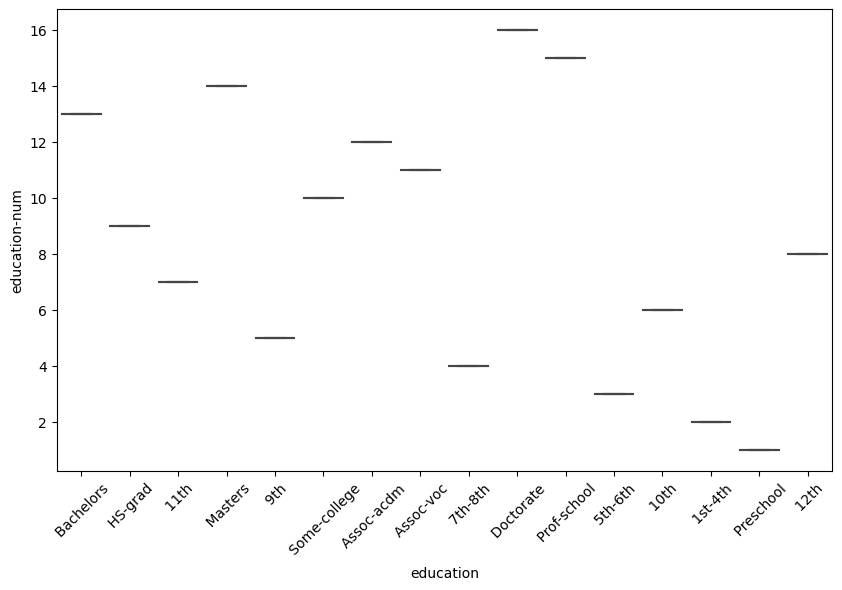

In [8]:
# Box plot of "education" and "education-num"
plt.figure(figsize=(10, 6))
sns.boxplot(x="education", y="education-num", data=df_train)
plt.xlabel("education")
plt.ylabel("education-num")
plt.xticks(rotation=45)
plt.show()

df_train = df_train.drop(columns="education-num")

In [9]:
categorical_cols = df_train.select_dtypes("object").columns

df_train[categorical_cols] = df_train[categorical_cols].apply(lambda x: x.str.strip())
nrows_before = len(df_train)
df_train = df_train[~df_train.apply(lambda row: row.astype(str).str.contains("\?").any(), axis=1)]
print(f"Number of missing values dropped: {nrows_before - len(df_train)}")

Number of missing values dropped: 2398


In [10]:
len(df_train)

30139

In [11]:
df_train.describe()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week
count,30139.000000,3.013900e+04,30139.000000,30139.000000,30139.000000
mean,38.441720,1.897950e+05,1092.841202,88.439928,40.934703
std,13.131426,1.056586e+05,7409.110596,404.445239,11.978753
min,17.000000,1.376900e+04,0.000000,0.000000,1.000000
25%,28.000000,1.176275e+05,0.000000,0.000000,40.000000
50%,37.000000,1.784170e+05,0.000000,0.000000,40.000000
75%,47.000000,2.376045e+05,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000


In [12]:
# Binning of sparse categories
df_train["workclass"] = np.where(df_train["workclass"] != "Private", "Non-private", df_train["workclass"])

assoc = ("Assoc-voc", "Assoc-acdm")
school = ("Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th")
df_train["education"] = df_train["education"].map(lambda x: "Associate" if x in assoc else x)
df_train["education"] = df_train["education"].map(lambda x: "School" if x in school else x)

marital_status_others = ("Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse")
df_train["marital-status"] = df_train["marital-status"].map(lambda x: "Others" if x in marital_status_others else x)

occupation_others = ("Priv-house-serv", "Armed-Forces")
df_train["occupation"] = df_train["occupation"].map(lambda x: "Others" if x in occupation_others else x)

df_train["race"] = np.where(df_train["race"] != "White", "Non-white", df_train["race"])

df_train["native-country"] = np.where(df_train["native-country"] != "United-States", "Others", df_train["native-country"])

# for col in categorical_cols:
#     plt.figure(figsize=(8, 6))
#     df_train[col].value_counts().plot(kind="bar", color="skyblue")
#     plt.xlabel(col)
#     plt.ylabel("Count")
#     plt.xticks(rotation=90)
#     plt.show()

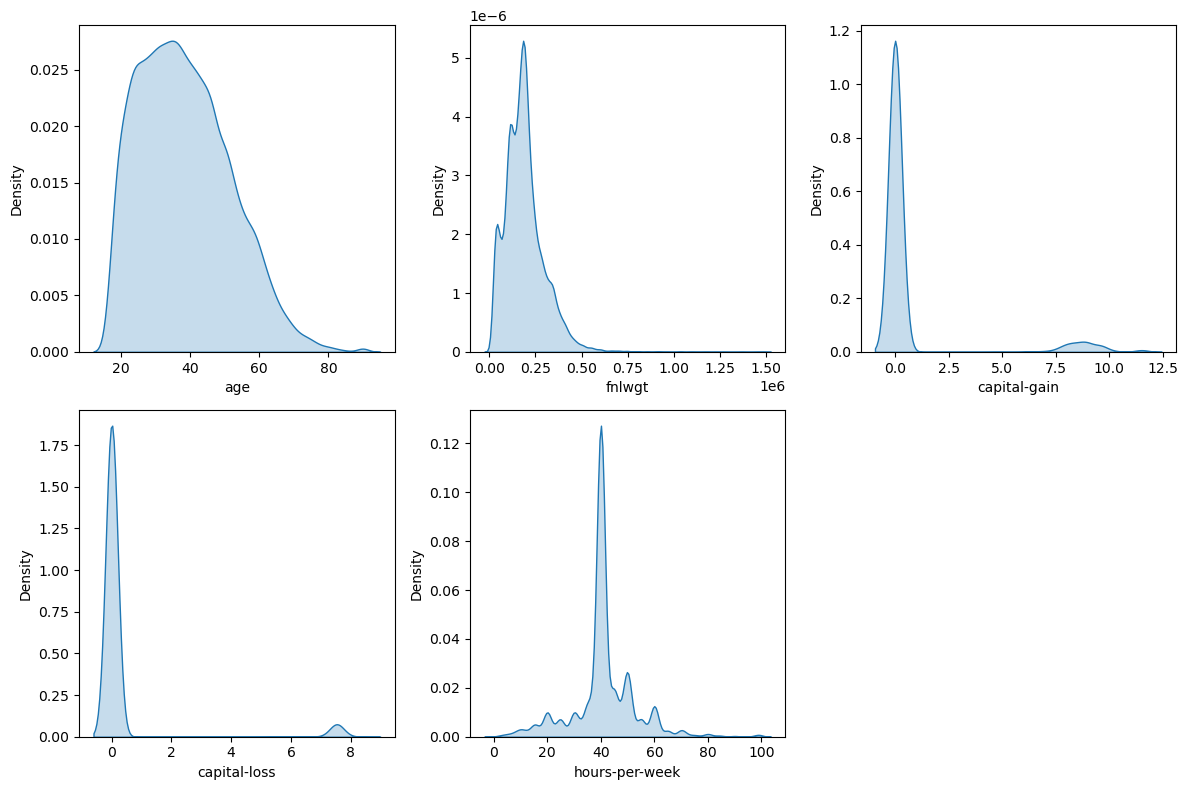

In [13]:
# Log transformation of skewed data and visualization of numerical data
numerical_cols = df_train.select_dtypes("number").columns

df_train["capital-gain"] = np.log1p(df_train["capital-gain"])
df_train["capital-loss"] = np.log1p(df_train["capital-loss"])

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(df_train[col], ax=axes[i], fill=True)
    axes[i].grid(False)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In [14]:
# Custom dictionary for label encoding
custom_label_encoder = {}

for col in categorical_cols:
    unique_values = df_train[col].unique()
    custom_label_encoder[col] = {value: count for count, value in enumerate(unique_values)}
    df_train[col] = df_train[col].replace(custom_label_encoder[col])

In [15]:
# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_train)
df_train = pd.DataFrame(scaled_data, columns=df_train.columns)

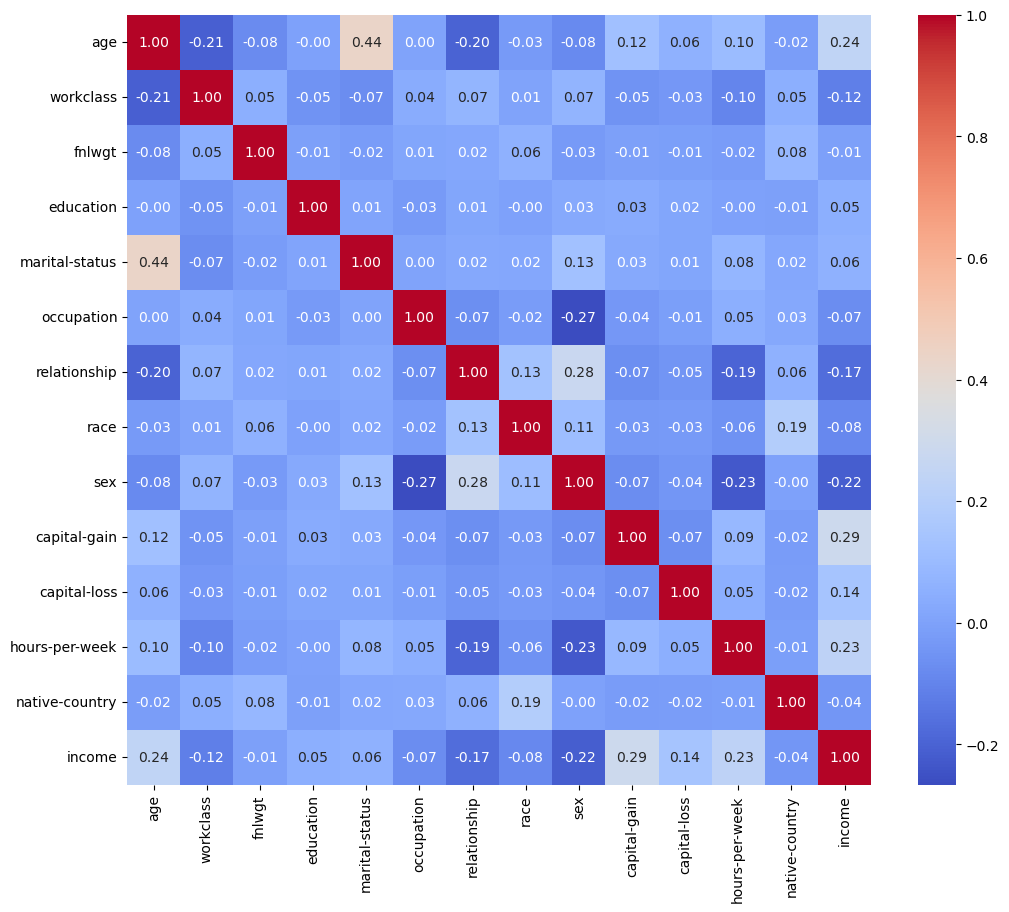

In [16]:
# Correlation heatmap of numerical variables
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [17]:
# Preprocessing for testing dataset
nrows_before = len(df_test)
df_test = df_test.drop_duplicates()
print(f"Number of duplicate rows dropped: {nrows_before - len(df_test)}")

df_test[categorical_cols] = df_test[categorical_cols].apply(lambda x: x.str.strip())
nrows_before = len(df_test)
df_test = df_test[~df_test.apply(lambda row: row.astype(str).str.contains("\?").any(), axis=1)]
print(f"Number of missing values dropped: {nrows_before - len(df_test)}")

df_test = df_test.drop(columns="education-num")

print(df_test.describe())

df_test["workclass"] = np.where(df_test["workclass"] != "Private", "Non-private", df_test["workclass"])
df_test["education"] = df_test["education"].map(lambda x: "Associate" if x in assoc else x)
df_test["education"] = df_test["education"].map(lambda x: "School" if x in school else x)
df_test["marital-status"] = df_test["marital-status"].map(lambda x: "Others" if x in marital_status_others else x)
df_test["occupation"] = df_test["occupation"].map(lambda x: "Others" if x in occupation_others else x)
df_test["race"] = np.where(df_test["race"] != "White", "Non-white", df_test["race"])
df_test["native-country"] = np.where(df_test["native-country"] != "United-States", "Others", df_test["native-country"])

for col in categorical_cols:
    print(f"{col}: {df_test[col].nunique()}")

df_test["capital-gain"] = np.log1p(df_test["capital-gain"])
df_test["capital-loss"] = np.log1p(df_test["capital-loss"])

for col in categorical_cols:
    df_test[col] = df_test[col].replace(custom_label_encoder[col])
    
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_test)
df_test = pd.DataFrame(scaled_data, columns=df_test.columns)

Number of duplicate rows dropped: 5
Number of missing values dropped: 1221
                age        fnlwgt  capital-gain  capital-loss  hours-per-week
count  15055.000000  1.505500e+04  15055.000000  15055.000000    15055.000000
mean      38.772036  1.896234e+05   1120.673663     89.071471       40.954234
std       13.380850  1.056081e+05   7704.433932    406.347469       12.062092
min       17.000000  1.349200e+04      0.000000      0.000000        1.000000
25%       28.000000  1.166570e+05      0.000000      0.000000       40.000000
50%       37.000000  1.779550e+05      0.000000      0.000000       40.000000
75%       48.000000  2.385895e+05      0.000000      0.000000       45.000000
max       90.000000  1.490400e+06  99999.000000   3770.000000       99.000000
workclass: 2
education: 8
marital-status: 4
occupation: 13
relationship: 6
race: 2
sex: 2
native-country: 2
income: 2


In [18]:
X_train = df_train.drop(columns=["income"])
y_train = df_train["income"]
X_test = df_test.drop(columns=["income"])
y_test = df_test["income"] 

### K-NN

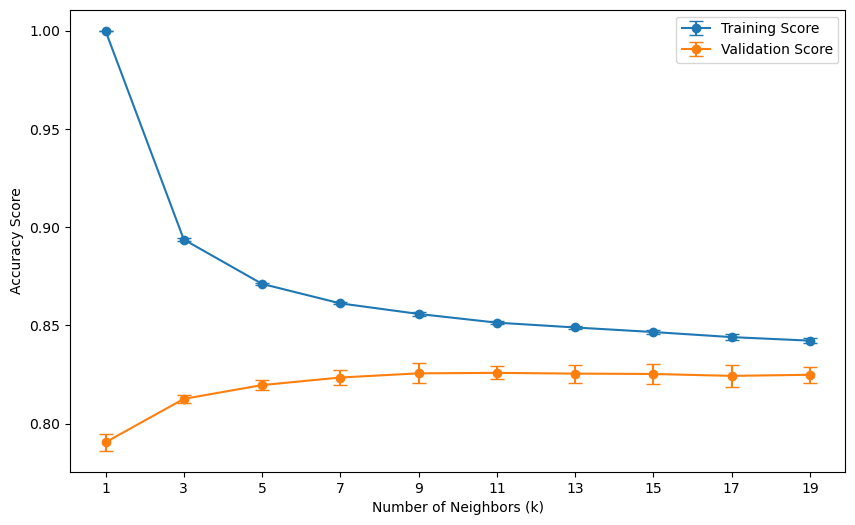

In [19]:
# Determining best k for K-NN
k_values = np.arange(1, 21, 2)

train_scores, valid_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train,
    param_name="n_neighbors", 
    param_range=k_values,    
    cv=5,                    
    scoring="accuracy"       
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.errorbar(k_values, train_scores_mean, yerr=train_scores_std, label="Training Score", marker="o", capsize=5)
plt.errorbar(k_values, valid_scores_mean, yerr=valid_scores_std, label="Validation Score", marker="o", capsize=5)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy Score")
plt.xticks(k_values)
plt.legend()
plt.grid(False)
plt.show()

In [20]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8233145134506809
Precision: 0.6579586877278251
Recall: 0.5854054054054054
F1-Score: 0.6195652173913043
Confusion Matrix:
[[10229  1126]
 [ 1534  2166]]


### Random Forest Classfier

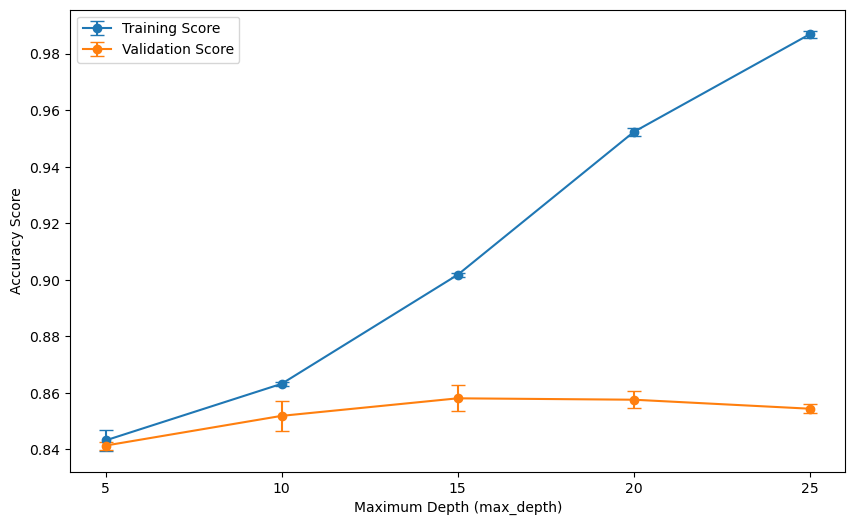

In [22]:
# Determining best max_depth for random forest classifier
max_depth_values = [5, 10, 15, 20, 25]

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 1.5}),
    X_train, y_train,
    param_name="max_depth", 
    param_range=max_depth_values,
    cv=5,
    scoring="accuracy"
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.errorbar(max_depth_values, train_scores_mean, yerr=train_scores_std, label="Training Score", marker='o', capsize=5)
plt.errorbar(max_depth_values, valid_scores_mean, yerr=valid_scores_std, label="Validation Score", marker='o', capsize=5)
plt.xlabel("Maximum Depth (max_depth)")
plt.ylabel("Accuracy Score")
plt.xticks(max_depth_values)
plt.legend()
plt.grid(False)
plt.show()

In [23]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, class_weight={0: 1, 1: 1.5})
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8458983726336765
Precision: 0.6960227272727273
Recall: 0.6621621621621622
F1-Score: 0.6786703601108034
Confusion Matrix:
[[10285  1070]
 [ 1250  2450]]
